In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk


In [2]:
############

model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
if HOST_ID == 'workstation':
    model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
else:
    model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

###############

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [3]:
stack = 'MD661'
section_to_filename = metadata_cache['sections_to_filenames'][stack]

windowing_id = 1

windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]
half_size = patch_size/2

grid_spec = (patch_size, spacing, w, h)

sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [4]:
metadata_cache['valid_filenames'][stack].index("MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206")

118

In [5]:
# filenames = [fn for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'][83:89]
filenames = [fn for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'][118:119]

In [27]:
roi_xmin = 414 * 8
roi_ymin = 1212 * 8
roi_w = 551 * 8
roi_h = 528 * 8

In [28]:
scoremap_viz_allSchemes_allFns_allStructs = defaultdict(lambda: defaultdict(dict))

# for low in [500, 600, 700, 800, 900, 1000]:
for low in [500]:
    
#     probs_allFns_allClasses = {}
#     scoremaps_allFns_allClasses = {}
    
    high = 0

    for fn in filenames:

        ####################

        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, fn=fn)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb, bbox_lossless=(roi_xmin,roi_ymin,roi_w,roi_h))
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        ############################

        sample_locations_roi = sample_locations[indices_roi]

        ###########################

        t = time.time()
        img_fp = DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=2, resol='lossless')
        download_from_s3(img_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('Download: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        img_blue = imread(img_fp)[..., 2]
        sys.stderr.write('Read: %.2f seconds\n' % (time.time() - t))

        sys.stderr.write("Linear limits arguments detected, so use linear mapping.\n")

        t = time.time()
        img_blue_intensity_normalized = rescale_intensity_v2(img_blue, low, high)
        sys.stderr.write('Convert: %.2f seconds\n' % (time.time() - t))

        img = img_blue_intensity_normalized

        patches = np.array([img[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224

        #############################

        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

        t1 = time.time()        
        data_iter = mx.io.NDArrayIter(
                        patches_mean_subtracted_input, 
                        batch_size=batch_size,
                        shuffle=False)
        outputs = model.predict(data_iter, always_output_list=True)
        features = outputs[0].asnumpy()

        del data_iter

        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1))

        ####################

        model_name = 'inception-bn-blue'
        classifier_id = 38

        classifier_properties = classifier_settings.loc[classifier_id]
        assert dataset_settings.loc[int(classifier_properties['train_set_id'].split('/')[0])]['network_model'] == model_name
        svm_id = int(classifier_properties['svm_id'])

        ########################

        available_classifiers = {svm_id: DataManager.load_classifiers(classifier_id=svm_id)}

        def clf_predict(stack, fn):

            clf_allClasses_ = available_classifiers[svm_id]

            probs_allClasses = {}

            for structure, clf in clf_allClasses_.iteritems():

                probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]

                probs_allClasses[structure] = probs

            return probs_allClasses

        t = time.time()
        
        probs_allClasses =  clf_predict(stack=stack, fn=fn)
#         probs_allFns_allClasses[fn] = clf_predict(stack=stack, fn=fn)

#         pool = Pool(NUM_CORES/2)
#         probs_allFns_allClasses = dict(zip(filenames, pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)))
#         pool.close()
#         pool.join()

        sys.stderr.write('Classifier predict: %.2f\n' % (time.time()-t))

        #############################

        downscale = 32

        ##############################

        def resample(fn):

#             try:
#                 _, sample_locations_roi = DataManager.load_patch_locations(stack=stack, fn=fn, win=windowing_id)
#             except Exception as e:
#                 sys.stderr.write('Error loading patch locations for %s: %s.\n' % (fn, str(e)))
#                 return

            downscaled_grid_y = np.arange(0, h, downscale)
            downscaled_grid_x = np.arange(0, w, downscale)
            downscaled_ny = len(downscaled_grid_y)
            downscaled_nx = len(downscaled_grid_x)

            scoremaps_allClasses = {}

            for structure in all_structures_with_classifiers:

#                 sparse_scores = probs_allFns_allClasses[fn][structure]
                sparse_scores = probs_allClasses[structure] 

                f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                a = (sample_locations_roi - half_size)/spacing
                f_grid[a[:,1], a[:,0]] = sparse_scores

                yinterps = (downscaled_grid_y - half_size)/float(spacing)
                xinterps = (downscaled_grid_x - half_size)/float(spacing)

                points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                coord = np.c_[points_y.flat, points_x.flat]
                f_interp = map_coordinates(f_grid, coord.T, order=1)
                f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                scoremap = f_interp_2d.astype(np.float16)

                scoremaps_allClasses[structure] = scoremap
            return scoremaps_allClasses

        t = time.time()
        scoremaps_allClasses = resample(fn)
#         scoremaps_allFns_allClasses[fn] = resample(fn)

#         pool = Pool(NUM_CORES/2)
#         # pool = Pool(1)
#         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
#         pool.close()
#         pool.join()

        sys.stderr.write('Resample: %.2f seconds\n' % (time.time() - t)) 

        ###########################

        add_label_text = True
        cmap_name = 'jet'
#         downscale = 8
#         structure = '7N'

        #########################

#         scoremap_viz_allFns = {}

#         for fn in filenames:

    
        def save_scoremap(structure):

            if add_label_text:
                label_text = str(structure)
            else:
                label_text = None
            scoremap_viz = scoremap_overlay_on(bg=img, in_downscale=1, stack=stack, fn=fn, structure=structure,
    #                                       scoremap=scoremaps_allFns_allClasses[fn][structure],
                                      scoremap=scoremaps_allClasses[structure],
                                      in_scoremap_downscale=32,
                                      out_downscale=8, label_text=label_text, 
                                      cmap_name=cmap_name)
            return scoremap_viz

        #             scoremap_viz_allFns[fn] = scoremap_viz

    #             scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn][structure] = scoremap_viz

        pool = Pool(NUM_CORES)
        structures = scoremaps_allClasses.keys()
        scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
        pool.close()
        pool.join()    

locate patches: 0.14 seconds
4553 samples.
Download: 2.48 seconds
Read: 173.97 seconds
Linear limits arguments detected, so use linear mapping.
Convert: 35.33 seconds
predict: 8.17 seconds


rm -rf "/home/yuncong/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/home/yuncong/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/home/yuncong/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/home/yuncong/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/home/yuncong/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/home/yuncong/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.
Classifier predict: 0.80
Resample: 1.35 seconds
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj

In [24]:
title_viz_tuples = [("%d,%d" % (lo,hi), vizs['7N'])
 for (lo, hi), x in sorted(scoremap_viz_allSchemes_allFns_allStructs.items())
 for fn, vizs in x.iteritems()]

In [25]:
titles, vizs = zip(*title_viz_tuples)

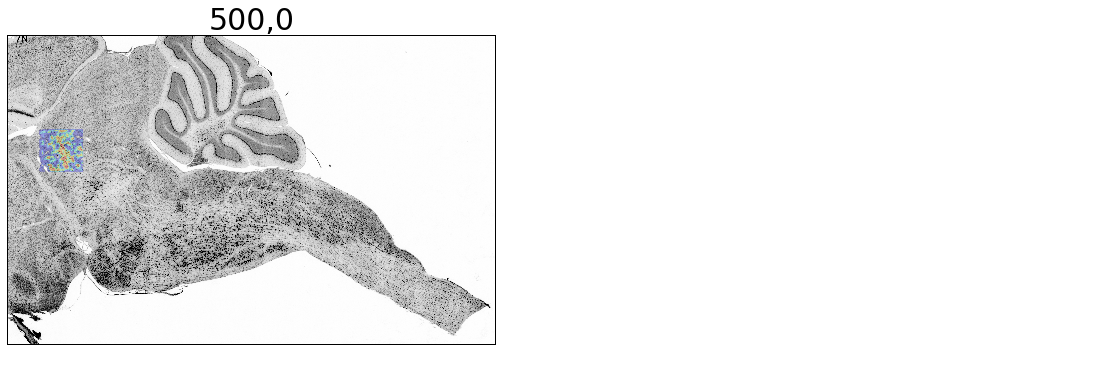

In [26]:
display_images_in_grids(vizs=vizs, titles=titles, nc=2)